 Importation librairies

In [16]:
# librairies
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_score, classification_report, confusion_matrix, accuracy_score, recall_score, f1_score
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from IPython.display import display
from numpy import concatenate

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import scipy.io as sp
import pandas as pd

Construction dataset + déclaration variables

In [17]:
#traitement fichier.mat
dataset=sp.loadmat('breastw.mat')
X = dataset['X']
y = dataset['y']
#fin traitement mat

#Variables pour test
liste_distances = ['euclidean', 'manhattan', 'chebyshev', 'minkowski', 'wminkowski', 'seuclidean', 'mahalanobis']
n_voisins = range(1,80,5) #nombre de voisins
#Fin variables

Modèles KNN / Statistique / Réseau de neurones / Perceptron simple / Stat semi-supervisé + entrainement dataset

In [18]:
skf = StratifiedKFold(n_splits=10,shuffle=True) # équilibrage dataset

for train_index, test_index in skf.split(X,y):
    
    test =False
    X_train, X_test = X[train_index,:], X[test_index,:]
    y_train, y_test = y[train_index], y[test_index]

    #copie pour semi-supervisé
    X_train_semiSup, y_train_semiSup = X[train_index,:], y[train_index]

    #Méthode Statistique Gaussienne
    model_gmm = GaussianMixture(n_components=2, covariance_type ='full', random_state = 0, max_iter=100)
    model_gmm.fit(X_train,y_train)
    y_pred_gmm = model_gmm.predict(X_test)
    y_scores_gmm = model_gmm.predict_proba(X_test)
    if precision_score(y_test,y_pred_gmm)< 0.15:
    
        y_pred_gmm = np.array([0 if label == 1 else 1 for label in y_pred_gmm])
        y_scores_gmm = 1-model_gmm.predict_proba(X_test)
        y_scores_gmm = y_scores_gmm[:, 1]
    else :
        y_scores_gmm = model_gmm.predict_proba(X_test)
        y_scores_gmm = y_scores_gmm[:, 1]
    #Fin méthode stat

    #Méthode KNN

    #for k in range(1,n_voisins,5) :
    for k in range(1,len(X_test),5) :
        for distance in liste_distances :
            #algo knn
            model_KNN = KNeighborsClassifier(n_neighbors=k, weights='distance', algorithm='auto', metric=distance)
            model_KNN.fit(X_train,y_train)
            y_pred_KNN = model_KNN.predict(X_test)
            model_PCA = PCA(n_components=2)
            data_reduced = model_PCA.fit_transform(X_test)
            #fin algo knn
            y_scores_KNN = model_KNN.predict_proba(X_test)
            y_scores_KNN = y_scores_KNN[:, 1]

            F1_KNN = round(f1_score(y_test,y_pred_KNN),3)
            recall_KNN = round(recall_score(y_test,y_pred_KNN),3)
            precision_KNN = round(precision_score(y_test,y_pred_KNN,zero_division=0),3)
            accuracy_KNN = round(accuracy_score(y_test,y_pred_KNN),3)
            AUC_KNN = round(roc_auc_score(y_test, y_scores_KNN),3)

            #matrice_KNN = np.array([['[{},{},{}]'.format(k,'distance',distance),F1_KNN,recall_KNN,precision_KNN,accuracy_KNN,AUC_KNN]])
            #matrice = np.append(matrice,np.array(['[{},{},{}]'.format(k,'distance',distance),F1_KNN,recall_KNN,precision_KNN,accuracy_KNN,AUC_KNN]).reshape(1,6),axis=0)
   
    #Fin méthode KNN


    #Algorithme Réseau de neurones = Perceptron multicouches
    #Modèle1
    model_PMC_1 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(8, 2), random_state=1)
    model_PMC_1.fit(X_train, y_train)
    y_pred_PMC_1= model_PMC_1.predict(X_test)
    #Fin alogo PMC
    y_scores_PMC_1 = model_PMC_1.predict_proba(X_test)
    y_scores_PMC_1 = y_scores_PMC_1[:, 1]
    #Fin méthode Réseaux de neurones

    #Méthode Perceptron simple
    PP = Perceptron(penalty='elasticnet') #random_state=42
    PP.fit(X_train, y_train)
    y_pred_PSC = PP.predict(X_test)
    #Modèle isotonique
    model_isotonic = CalibratedClassifierCV(PP, cv='prefit', method='isotonic') #il faut encore fait la validation croisée au début (équilibrer notre dataset)
    #CV correspond à la validation croisée, si dataset déjà rééquilibré : cv = 'predict'
    model_isotonic.fit(X_test, y_test)
    y_score_PSC = model_isotonic.predict_proba(X_test)
    y_score_PSC = y_score_PSC[:, 1]
    #Fin Perceptron simple


    #Méthode semi-supervisée
    for train_index_2, test_index_2 in skf.split(X_train_semiSup,y_train_semiSup):
        X_train_2, X_delab = X_train_semiSup[train_index_2,:], X_train_semiSup[test_index_2,:]
        y_train_2, y_delab = y_train_semiSup[train_index_2], y_train_semiSup[test_index_2]
        
        y_train_2 = np.ravel(y_train_2)
        X_train_mixed = concatenate((X_train_2, X_delab))

        y_delab = [-1 for i in range(len(y_delab))]
        y_delab = np.ravel(y_delab)

        #Algorithme SVC
        model_svc_semiSup = SVC()
        model_svc_semiSup.fit(X_train_2,y_train_2)
        y_delab = model_svc_semiSup.predict(X_delab)

        #Algorithme Gaussien semi-supervisé
        y_train_mixed = concatenate((y_delab,y_train_2))
        model_gmm_semiSup = GaussianMixture(n_components=2, covariance_type ='full', random_state = None, max_iter=100)
        model_gmm_semiSup.fit(X_train_mixed,y_train_mixed)
        y_pred_semiSup = model_gmm_semiSup.predict(X_test)

        if precision_score(y_test,y_pred_semiSup)< 0.15:
    
            y_pred_semiSup = np.array([0 if label == 1 else 1 for label in y_pred_semiSup])
            y_scores_gmm_semiSup = 1-model_gmm_semiSup.predict_proba(X_test)
            y_scores_gmm_semiSup = y_scores_gmm_semiSup[:, 1]
        else :
            y_scores_gmm_semiSup = model_gmm_semiSup.predict_proba(X_test)
            y_scores_gmm_semiSup = y_scores_gmm_semiSup[:, 1]

df_KNN=pd.DataFrame(matrice_KNN,columns=['Combinaison','F1 score','Recall','Precision','Accuracy','AUC'])
df_KNN = df_KNN.astype({'F1 score': float, 'Recall': float,'Precision': float,'Accuracy': float,'AUC': float})
filtered_values_1 = np.where((df_KNN['F1 score']>=0.93) & (df_KNN['Recall']>=0.925) & (df_KNN['Precision']>=0.925) & (df_KNN['AUC']>=0.925))
display(df_KNN.loc[filtered_values_1].sort_values(by=['AUC'], ascending=False))

C:\Users\achan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\achan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\achan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\achan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sam

TypeError: __init__() takes exactly 2 positional arguments (1 given)

Plot nuage de points / Courbes ROC

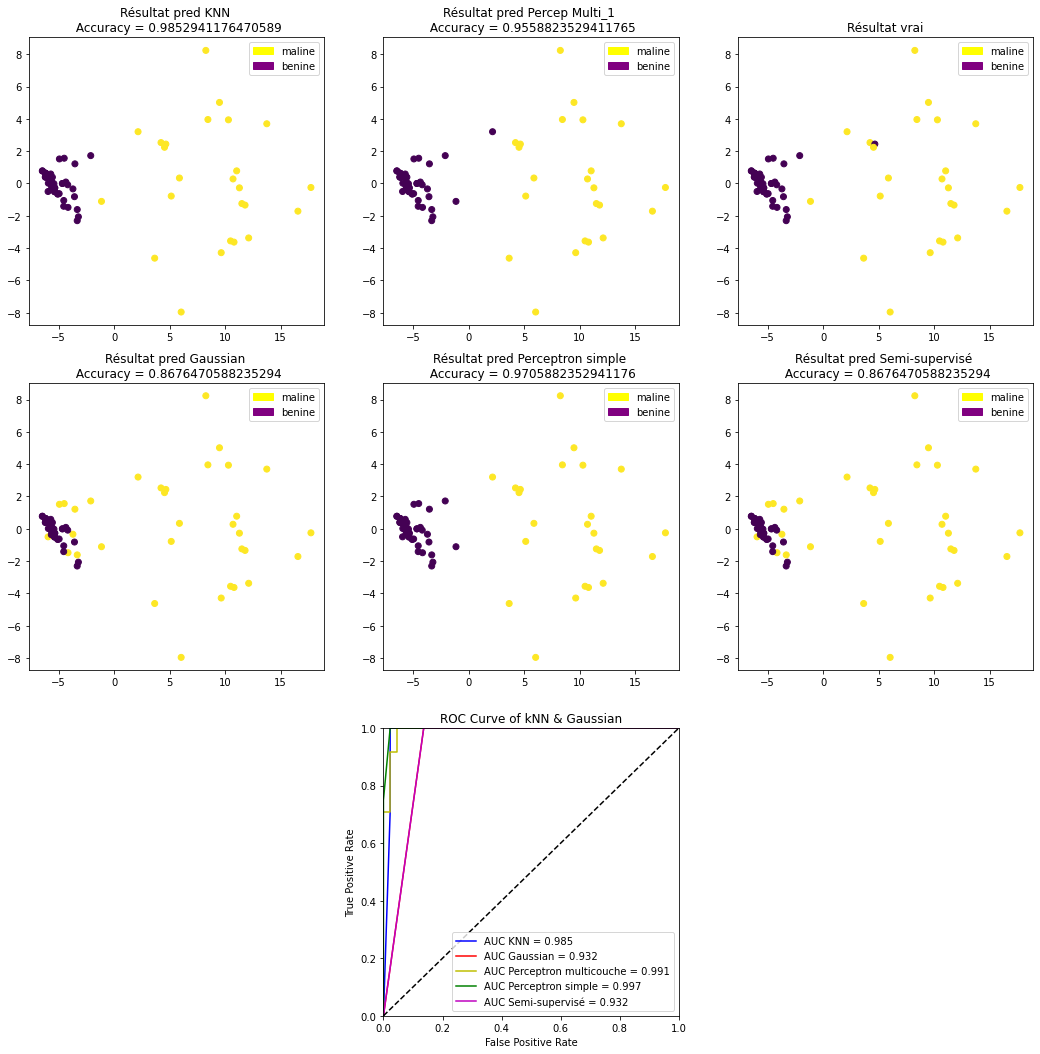

In [ ]:
plt.figure(figsize=(18,18))

#Calculs Accuracy KNN
Accuracy_KNN = accuracy_score(y_test, y_pred_KNN)
Accuracy_gmm = accuracy_score(y_test, y_pred_gmm)
Accuracy_PMC_1 = accuracy_score(y_test, y_pred_PMC_1)
Accuracy_PSC = accuracy_score(y_test, y_pred_PSC)
Accuracy_semiSup = accuracy_score(y_test, y_pred_semiSup)

#Nuage de points prédictif KNN
plt.subplot(3, 3, 1)
plt.scatter(data_reduced[:,0],data_reduced[:,1],c=y_pred_KNN) 
plt.title("Résultat pred KNN \n Accuracy = {}".format(Accuracy_KNN))
maline = mpatches.Patch(color='yellow', label='maline')
benine = mpatches.Patch(color='purple', label='benine')
plt.legend(handles=[maline,benine])

#Nuage de points prédictif Gaussien
plt.subplot(3, 3, 4)
plt.scatter(data_reduced[:,0],data_reduced[:,1],c=y_pred_gmm) 
plt.title("Résultat pred Gaussian \n Accuracy = {}".format(Accuracy_gmm))
maline = mpatches.Patch(color='yellow', label='maline')
benine = mpatches.Patch(color='purple', label='benine')
plt.legend(handles=[maline,benine])

#Nuage de points prédictif Perceptron multicouche modèle 1
plt.subplot(3, 3, 2)
plt.scatter(data_reduced[:,0],data_reduced[:,1],c=y_pred_PMC_1) 
plt.title("Résultat pred Percep Multi_1 \n Accuracy = {}".format(Accuracy_PMC_1))
maline = mpatches.Patch(color='yellow', label='maline')
benine = mpatches.Patch(color='purple', label='benine')
plt.legend(handles=[maline,benine])

#Nuage de points prédictif Perceptron simplecouche
plt.subplot(3, 3, 5)
plt.scatter(data_reduced[:,0],data_reduced[:,1],c=y_pred_PSC) 
plt.title("Résultat pred Perceptron simple \n Accuracy = {}".format(Accuracy_PSC))
maline = mpatches.Patch(color='yellow', label='maline')
benine = mpatches.Patch(color='purple', label='benine')
plt.legend(handles=[maline,benine])

#Nuage de points prédictif Semi-supervisé
plt.subplot(3, 3, 6)
plt.scatter(data_reduced[:,0],data_reduced[:,1],c=y_pred_semiSup) 
plt.title("Résultat pred Semi-supervisé \n Accuracy = {}".format(Accuracy_semiSup))
maline = mpatches.Patch(color='yellow', label='maline')
benine = mpatches.Patch(color='purple', label='benine')
plt.legend(handles=[maline,benine])

#Nuage de points vrai
plt.subplot(3, 3, 3)
plt.scatter(data_reduced[:,0],data_reduced[:,1],c=y_test) 
plt.title("Résultat vrai")
maline = mpatches.Patch(color='yellow', label='maline')
benine = mpatches.Patch(color='purple', label='benine')
plt.legend(handles=[maline,benine])

#  ROC curve
 #ROC pour KNN
fpr_KNN, tpr_KNN, threshold_KNN = roc_curve(y_test, y_scores_KNN) 
roc_auc_KNN = auc(fpr_KNN, tpr_KNN)
 #ROC pour Gaussien
fpr_gmm, tpr_gmm, thresholds_gmm = roc_curve(y_test,y_scores_gmm)
roc_auc_gmm = auc(fpr_gmm, tpr_gmm)
 #ROC pour Perceptron multicouche modèle 1
fpr_PMC_1, tpr_PMC_1, thresholds_PMC_1 = roc_curve(y_test,y_scores_PMC_1)
roc_auc_PMC_1 = auc(fpr_PMC_1, tpr_PMC_1)
 #ROC pour Perceptron simple
fpr_PSC, tpr_PSC, thresholds_PSC = roc_curve(y_test,y_score_PSC)
roc_auc_PSC = auc(fpr_PSC, tpr_PSC)
 #ROC pour Semi-supervisé
fpr_semiSup, tpr_semiSup, thresholds_semiSup = roc_curve(y_test,y_scores_gmm_semiSup)
roc_auc_semiSup = auc(fpr_semiSup, tpr_semiSup)

plt.subplot(3, 3, 8)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_KNN, tpr_KNN, 'b', label = 'AUC KNN = %0.3f' % roc_auc_KNN)
plt.plot(fpr_gmm, tpr_gmm, 'r', label = 'AUC Gaussian = %0.3f' % roc_auc_gmm)
plt.plot(fpr_PMC_1, tpr_PMC_1, 'y', label = 'AUC Perceptron multicouche = %0.3f' % roc_auc_PMC_1)
plt.plot(fpr_PSC, tpr_PSC, 'g', label = 'AUC Perceptron simple = %0.3f' % roc_auc_PSC)
plt.plot(fpr_semiSup, tpr_semiSup, 'm', label = 'AUC Semi-supervisé = %0.3f' % roc_auc_semiSup)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN & Gaussian')
plt.show()
#fin graphique

Matrices de confusion / Rapports de classification

In [ ]:
# Méthode KNN
result = confusion_matrix(y_test, y_pred_KNN)
print("Matrice de confusion KNN :")
print(result)
result1 = classification_report(y_test, y_pred_KNN)
print("Classification Report KNN :",)
print (result1)
print("Accuracy KNN :", Accuracy_KNN, "\n")

# Méthode Statistique Gaussien
result = confusion_matrix(y_test, y_pred_gmm)
print("Matrice de confusion Gaussien :")
print(result)
result1 = classification_report(y_test, y_pred_gmm)
print("Classification Report Gaussian :",)
print (result1)
print("Accuracy Gaussian :", Accuracy_gmm)

# Méthode Perceptron multicouche
result = confusion_matrix(y_test, y_pred_PMC_1)
print("Matrice de confusion Perceptron multicouche :")
print(result)
result1 = classification_report(y_test, y_pred_PMC_1)
print("Classification Report Perceptron multicouche :",)
print (result1)
print("Accuracy Perceptron multicouche :", Accuracy_PMC_1)

# Méthode Perceptron simple couche
result = confusion_matrix(y_test, y_pred_PSC)
print("Matrice de confusion Perceptron simple :")
print(result)
result1 = classification_report(y_test, y_pred_PSC)
print("Classification Report Perceptron simple :",)
print (result1)
print("Accuracy Perceptron simple :", Accuracy_PSC)

# Méthode Semi-supervisé
result = confusion_matrix(y_test, y_pred_semiSup)
print("Matrice de confusion Semi-supervisé :")
print(result)
result1 = classification_report(y_test, y_pred_semiSup)
print("Classification Report Semi-supervisé :",)
print (result1)
print("Accuracy Semi-supervisé :", Accuracy_semiSup)


Matrice de confusion KNN :
[[43  1]
 [ 0 24]]
Classification Report KNN :
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        44
           1       0.96      1.00      0.98        24

    accuracy                           0.99        68
   macro avg       0.98      0.99      0.98        68
weighted avg       0.99      0.99      0.99        68

Accuracy KNN : 0.9852941176470589 

Matrice de confusion Gaussien :
[[35  9]
 [ 0 24]]
Classification Report Gaussian :
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        44
           1       0.73      1.00      0.84        24

    accuracy                           0.87        68
   macro avg       0.86      0.90      0.86        68
weighted avg       0.90      0.87      0.87        68

Accuracy Gaussian : 0.8676470588235294
Matrice de confusion Perceptron multicouche :
[[43  1]
 [ 2 22]]
Classification Report Perceptron multicouche :
 